# Bone age prediction of hand radiographs using Neural Networks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 16

## Retrieve datasets

In [4]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
      with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')

In [5]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

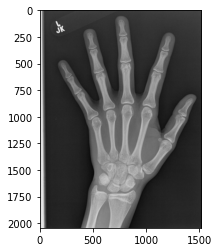

In [6]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

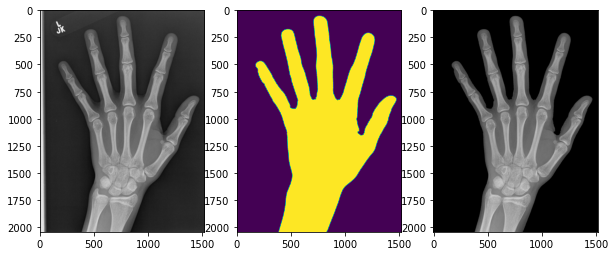

In [7]:
masks_path = 'boneage-training-dataset-masks'
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))

## Loading filenames

In [8]:
def load_filenames(file, path, path_p=None):
  if 'Test' in file:
    df = pd.read_excel(file)
  else:
    df = pd.read_csv(file)

  # Uniforming the dfs
  # reorder columns
  if 'train' in file:
    df = df[['id', 'male', 'boneage']]
  
  # rename columns
  df.set_axis(['image', 'gender(M/F)', 'boneage'], axis=1, inplace=True)

  # changing values for gender
  df['gender(M/F)'].replace({'M':np.array([0]), 'F':np.array([1])}, inplace=True) # for test set only
  df['gender(M/F)'].replace({True:np.array([0]), False:np.array([1])}, inplace=True) 

  # setting up the paths to get the images
  if path_p: # validation set images are divided in two folders
    mask_1 = df['image'] < 9727
    mask_2 = df['image'] >= 9727
    df.loc[mask_1, 'image'] = path + '/' + df.loc[mask_1, 'image'].astype(str) + '.png'
    df.loc[mask_2, 'image'] = path_p + '/' + df.loc[mask_2, 'image'].astype(str) + '.png'
  else: 
    df['image'] = path + '/' + df['image'].astype(str) + '.png'

  return df

In [9]:
train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv',
                               val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx',
                         data_dirs[2] + '/Test Set Images')

In [10]:
display(train_df)
display(validation_df)
display(test_df)

,image,gender(M/F),boneage
0,boneage-training-dataset/1377.png,1,180
1,boneage-training-dataset/1378.png,1,12
2,boneage-training-dataset/1379.png,1,94
3,boneage-training-dataset/1380.png,0,120
4,boneage-training-dataset/1381.png,1,82
...,...,...,...
12606,boneage-training-dataset/15605.png,1,50
12607,boneage-training-dataset/15606.png,1,113
12608,boneage-training-dataset/15608.png,1,55
12609,boneage-training-dataset/15609.png,0,150


,image,gender(M/F),boneage
0,boneage-validation-dataset-1/1386.png,1,30
1,boneage-validation-dataset-1/1392.png,0,162
2,boneage-validation-dataset-1/1397.png,1,18
3,boneage-validation-dataset-1/1401.png,1,132
4,boneage-validation-dataset-1/1410.png,0,57
...,...,...,...
1420,boneage-validation-dataset-2/15592.png,1,42
1421,boneage-validation-dataset-2/15601.png,1,132
1422,boneage-validation-dataset-2/15607.png,0,186
1423,boneage-validation-dataset-2/15611.png,1,120


,image,gender(M/F),boneage
0,Bone Age Test Set/Test Set Images/4360.png,0,168.934249
1,Bone Age Test Set/Test Set Images/4361.png,0,169.652678
2,Bone Age Test Set/Test Set Images/4362.png,0,73.256112
3,Bone Age Test Set/Test Set Images/4363.png,0,152.862669
4,Bone Age Test Set/Test Set Images/4364.png,0,135.456954
...,...,...,...
195,Bone Age Test Set/Test Set Images/4555.png,1,133.486757
196,Bone Age Test Set/Test Set Images/4556.png,1,129.254493
197,Bone Age Test Set/Test Set Images/4557.png,1,167.685033
198,Bone Age Test Set/Test Set Images/4558.png,1,135.980312


### Create the datasets

**PS** *Bring this two functions below inside a .py file and import it*

In [11]:
def load_hand_image(img_name):
    num_row = 512
    num_col = 512

    if isinstance(img_name, bytes):
        img_name = img_name.decode()

    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    img = np.array(cv2.resize(img, (num_row, num_col)), dtype='float32')
    plt.imshow(img)

    return img

In [12]:
def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.

In [13]:
def create_dataset(file_names, batch_size, shuffle, cache_file=None):
# def create_dataset(path, file_names, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_hand_image, [file_name], tf.float32))
    # py_func = lambda file_name: (tf.numpy_function(load_hand_image, [path + file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder.
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [14]:
batch_size = 32
train_dataset = create_dataset(train_df['image'],
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

val_dataset = create_dataset(validation_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

test_dataset = create_dataset(test_df['image'],
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='test_cache')

train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))
test_steps = int(np.ceil(test_df.shape[0] / batch_size))

## Data augmentation, Batching, Normalization : check LAB4 - ImageDataGenerator

Otherwise use functions below

In [15]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [16]:
def random_crop(input_image):
  cropped_image = tf.image.random_crop(input_image, size=[2, IMG_SIZE, IMG_SIZE, 3])

  return cropped_image

In [17]:
@tf.function()
def random_jitter(input_image):
  # Resizing to 286x286
  input_image = resize(input_image, 286, 286)

  # Random cropping back to 256x256
  input_image = random_crop(input_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)

  return input_image

In [18]:
def load_image_train(image_file):
  input_image = load(image_file)
  input_image = random_jitter(input_image)
  input_image = normalize(input_image)

  return input_image, real_image

In [19]:
def load_image_test(image_file):
  input_image = load(image_file)
  input_image = resize(input_image, IMG_SIZE, IMG_SIZE)
  input_image = normalize(input_image)

  return input_image

## Create the Model for prediction

In this case we substitute the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

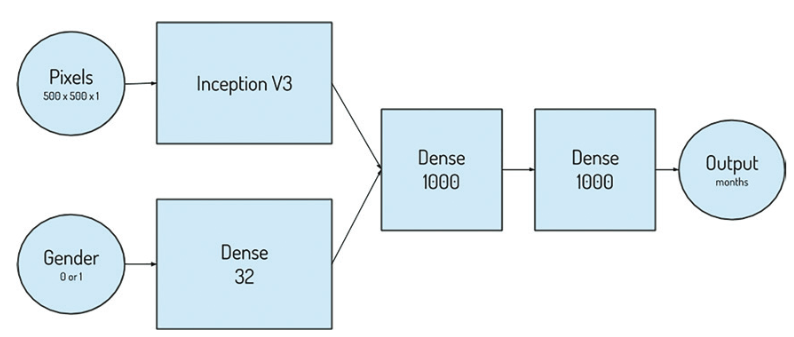

In [20]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py

In [21]:
from inc_v4 import *
from tensorflow.keras.applications.inception_v3 import InceptionV3

def Bone_Age():
  
  # X_input = Input(shape=(512, 512, 1)) # we should use grayscale images
  X_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
  gen_input = Input(shape=(1,))
  
  # Inception block
  X = Inceptionv4(X_input, include_top=False) # 14 x 14 x 1536
  # to use it as a model check Github

  X = AveragePooling2D((2, 2))(X) # 7 x 7 x 1536 (or 2048 for v3)
  X = Flatten()(X)

  # Dense block (gender)
  gen = Dense(32, activation='relu')(gen_input)

  # Concatenation
  X = tf.concat(values=[X, gen], axis=1)

  # First Dense block
  X = Dense(1000, activation='relu')(X)

  # Second Dense block
  X = Dense(1000, activation='relu')(X)

  # Fully connected layer
  X = Dense(1)(X)

  return tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name='Bone_Age')

In [22]:
std_bone_age = train_df.loc[:150, 'boneage'].std() # to change
mean_bone_age = train_df.loc[:150, 'boneage'].mean() # to change

In [23]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [24]:
model = Bone_Age()
model.compile(optimizer="adam", loss="mse", metrics=[mae_in_months])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae", "accuracy"])
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Let's try to implement a simpler model

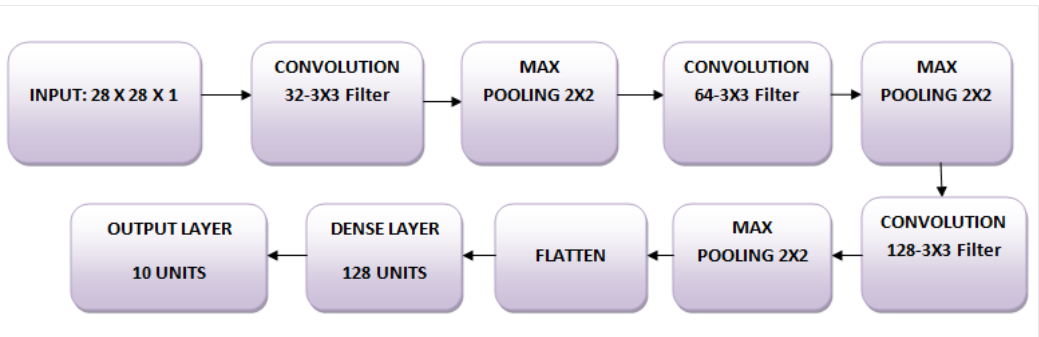

In [25]:
def Simple_Conv():
  X_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
  gen_input = Input(shape=(1,))

  # Convolutional block
  X = Conv2D(32, (3,3), activation='relu')(X_input)
  X = MaxPooling2D((2, 2))(X)
  X = Conv2D(64, (3,3), activation='relu')(X)
  X = MaxPooling2D((2, 2))(X)
  X = Conv2D(128, (3,3), activation='relu')(X)
  X = MaxPooling2D((2, 2))(X)
  X = Flatten()(X)
  # X = Dense(128, activation='relu')(X)

  # Dense block (gender)
  gen = Dense(32, activation='relu')(gen_input)

  # Concatenation
  X = tf.concat(values=[X, gen], axis=1)

  # First Dense block
  X = Dense(1000, activation='relu')(X)

  # Second Dense block
  X = Dense(1000, activation='relu')(X)

  # Fully connected layer
  X = Dense(1)(X)

  return tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name='Simple_Conv')

In [26]:
conv_model = Simple_Conv()
conv_model.compile(optimizer="adam", loss="mse", metrics=[mae_in_months])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae", "accuracy"])
# tf.keras.utils.plot_model(conv_model, show_shapes=True, dpi=64)

### Let's see if everything works correctly with the first 200 images

First apply the masks

In [26]:
masks_path = 'boneage-training-dataset-masks/'
for index in range(200):
  im_path = train_df.loc[index, 'image']
  im_name = im_path.split('/')[1]
  image = cv2.imread(im_path)
  mask_im = cv2.imread(path + '/' + masks_path + im_name, 0)
  # apply mask to original image
  masked_im = cv2.bitwise_and(image, image, mask=mask_im)
  # resize image
  masked_im = cv2.resize(masked_im, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
  # overwrite the original image with its masked version
  cv2.imwrite(im_path, masked_im)

In [27]:
# TRY TO CONVERT THE ABOVE FUNCTION IN A MAP FUNCTION
# mask_func = lambda image: cv2.imwrite(masked_path + image.split('/')[1], cv2.bitwise_and(
#     cv2.imread(image), cv2.imread(image), 
#     mask=cv2.imread(path + '/' + masks_path + image.split('/')[1], 0)))
# temp = train_df.copy()
# temp.loc[:, 'image'] = temp.loc[:, 'image'].map(mask_func)

Divide the dataset

In [28]:
train_data = train_df.iloc[:150]
val_data = train_df.iloc[150:180]
test_data = train_df.iloc[180:200]

In [29]:
# Create a callback for early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [30]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip images
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

## Try with raw images

In [37]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_excel('Bone Age Test Set/Bone age ground truth.xlsx')

train_df['id'] = train_df['id'].apply(lambda x: str(x) + '.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x) + '.png')
# train_df['id'] = train_df['id'].apply(lambda x: '/content/boneage-trainnig-dataset'+ str(x) + '.png')
# test_df['Case ID'] = test_df['Case ID'].apply(lambda x: '/content/Bone Age Test Set/Test Set Images' + str(x) + '.png')

In [ ]:
display(train_df[:5])
display(test_df[:5])

In [39]:
train_df['gender'] = train_df['male'].apply(lambda x: 1 if x else 0)
test_df['gender'] = test_df['Sex'].apply(lambda x: 1 if x=='M' else 0)

In [40]:
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
print(mean_bone_age, std_bone_age)

127.3207517246848 41.182021399396326


In [41]:
# normalize to improve training
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
train_df.head()

,id,boneage,male,gender,boneage_z
0,1377.png,180,False,0,1.279181
1,1378.png,12,False,0,-2.800269
2,1379.png,94,False,0,-0.809109
3,1380.png,120,True,1,-0.177766
4,1381.png,82,False,0,-1.100498


In [42]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(train_df, test_size=0.2, random_state=0)

train_steps = int(np.ceil(df_train.shape[0] / batch_size))
val_steps = int(np.ceil(df_valid.shape[0] / batch_size))

In [51]:
def gen_2inputs(datagen, df, dir, batch_size, shuffle=False, seed=None):
    gen_img = datagen.flow_from_dataframe(dataframe=df, directory = dir,
        x_col='id', y_col='boneage_n', batch_size=batch_size, seed=seed, shuffle=shuffle, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale', drop_duplicates=False)
    
    gen_gender = datagen.flow_from_dataframe(dataframe=df, directory = dir,
        x_col='id', y_col='gender', batch_size=batch_size, seed=seed, shuffle=shuffle, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale', drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [52]:
datagen_train = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)
datagen_val = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator()

train_gen = gen_2inputs(datagen_train, df_train, '/content/boneage-training-dataset', batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, df_valid, '/content/boneage-training-dataset', batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, '/content/Bone Age Test Set', test_df.shape[0])

In [ ]:
test_X, test_Y = next(datagen_val.flow_from_dataframe( 
                            df_valid, 
                            directory = '/content/boneage-training-dataset',
                            x_col = 'id',
                            y_col = 'boneage_z', 
                            target_size = (IMG_SIZE, IMG_SIZE),
                            batch_size = df_valid.shape[0],
                            class_mode = 'other'
                            ))

Found 2523 validated image filenames.


In [53]:
m = Bone_Age()
# m.compile(loss='mse', optimizer='adam', metrics=[mae_in_months])
m.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])
# m.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience= 5, verbose=0, mode='auto')
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)

model_history = m.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=5, callbacks=[early_stopping, red_lr_plat])
model_history

Found 10088 validated image filenames.
Found 10088 validated image filenames.
Epoch 1/5
315/315 [==============================] - ETA: 0s - loss: 0.8852 - mae_in_months: 36.4563Found 2523 validated image filenames.
Found 2523 validated image filenames.
315/315 [==============================] - 690s 2s/step - loss: 0.8852 - mae_in_months: 36.4563 - val_loss: 0.7497 - val_mae_in_months: 30.8726 - lr: 0.0010
Epoch 2/5
315/315 [==============================] - 659s 2s/step - loss: 0.7446 - mae_in_months: 30.6624 - val_loss: 1.0613 - val_mae_in_months: 43.7048 - lr: 0.0010
Epoch 3/5
105/315 [=========>....................] - ETA: 7:00 - loss: 0.7146 - mae_in_months: 29.4271

In [ ]:
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size=32, verbose=True))
test_months = mean_bone_age + std_bone_age*(test_Y)

print((pred[i], test_months[i]) for i in range(len(pred)))

79/79 [==============================] - 10s 104ms/step
<generator object <genexpr> at 0x7f159f06d7b0>


In [ ]:
test_gen.reset()
y_pred = model_2.predict(test_gen)
predict = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predict)
print((predicted[i]))

7/7 [==============================] - 6s 750ms/step


NameError: ignored